In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import shutil
import os

# Define your destination path in Google Drive
drive_output_path = '/content/drive/My Drive/NuInsSeg/dualdecodermodel2'
os.makedirs(drive_output_path, exist_ok=True)
opts = {}
opts['number_of_channel'] = 3
opts['treshold'] = 0.5
opts['epoch_num'] = 100
opts['quick_run'] = 1
opts['batch_size'] = 4
opts['random_seed_num'] = 19
opts['k_fold'] = 5
opts['save_val_results'] = 1
opts['init_LR'] = 0.001
opts['LR_decay_factor'] = 0.5
opts['LR_drop_after_nth_epoch'] = 20
opts['crop_size'] = 512
## output directories
opts['result_save_path'] ='prediction_image/'
opts['result_save_path'] = os.path.join(drive_output_path, opts['result_save_path'])
opts['model_save_path'] ='output_model/'
opts['model_save_path'] = os.path.join(drive_output_path, opts['model_save_path'])

In [3]:
import os
from glob import glob
import numpy as np
from sklearn.model_selection import KFold,StratifiedKFold
import time
import cv2
import keras
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from albumentations import *
from keras import backend as K
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import skimage.morphology
from skimage.io import imsave
from skimage.morphology import remove_small_objects
import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
print('Chicken')

Chicken


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ipateam/nuinsseg")

print("Path to dataset files:", path)

100%|██████████| 1.52G/1.52G [00:10<00:00, 151MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5


In [5]:
# base_path = '/kaggle/input/nuinsseg/'
base_path = path
organ_names = [ name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) ]
organ_names

['mouse spleen',
 'mouse muscle_tibia',
 'mouse heart',
 'human cerebellum',
 'human lung',
 'human tonsile',
 'human jejunum',
 'human muscle',
 'mouse fat (white and brown)_subscapula',
 'human cardia',
 'human tongue',
 'human liver',
 'human oesophagus',
 'human spleen',
 'mouse thymus',
 'human kidney',
 'human bladder',
 'human rectum',
 'human testis',
 'human salivory gland',
 'mouse femur',
 'human placenta',
 'human pancreas',
 'human umbilical cord',
 'human epiglottis',
 'mouse liver',
 'human melanoma',
 'human peritoneum',
 'human brain',
 'mouse kidney',
 'human pylorus']

In [6]:
# input and outpu paths
img_path = glob(os.path.join(base_path, '*/tissue images/', '*.png'))
binary_mask_path = glob(os.path.join(base_path, '*/mask binary/', '*.png'))
distance_mask_path = glob(os.path.join(base_path, '*/distance maps/', '*.png'))
label_mask_path = glob(os.path.join(base_path, '*/label masks modify/', '*.tif'))
vague_mask_path =  glob(os.path.join(base_path, '*/vague areas/mask binary/', '*.png'))


img_path.sort()
binary_mask_path.sort()
distance_mask_path.sort()
label_mask_path.sort()
vague_mask_path.sort()


# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('prediction_image/'):
    os.makedirs('prediction_image/')
if not os.path.exists('output_model/'):
    os.makedirs('output_model/')
if not os.path.exists(opts['result_save_path']+ 'validation/unet'):
    os.makedirs(opts['result_save_path'] + 'validation/unet')
if not os.path.exists(opts['result_save_path']+ 'validation/watershed_unet'):
    os.makedirs(opts['result_save_path'] + 'validation/watershed_unet')

In [7]:
rand_num = np.random.randint(len(img_path))
print('image path: {}\n'.format(img_path[rand_num]),
      'binary mask path: {}\n'.format(binary_mask_path[rand_num]),
      'distance mask path: {}\n'.format(distance_mask_path[rand_num]),
      'label mask path: {}\n'.format(label_mask_path[rand_num]))

image path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/human placenta/tissue images/human_placenta_36.png
 binary mask path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/human placenta/mask binary/human_placenta_36.png
 distance mask path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/human placenta/distance maps/human_placenta_36.png
 label mask path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/human placenta/label masks modify/human_placenta_36.tif



In [8]:
# learning rate scheduler
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, epochs_drop=1000):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/epochs_drop))

    return LearningRateScheduler(schedule, verbose = 1)

In [9]:
import tensorflow as tf
from skimage.io import imread

IMG_SIZE = (256,256)
BATCH_SIZE = 8

def load_image(path, target_size=IMG_SIZE):
    im = imread(path)
    if im.ndim == 2:  # grayscale → RGB
        im = np.stack([im]*3, axis=-1)
    im = cv2.resize(im, target_size)
    return im.astype("float32")/255.0

def load_mask(path, target_size=IMG_SIZE):
    m = imread(path)
    m = cv2.resize(m, target_size, interpolation=cv2.INTER_NEAREST)
    return (m>127).astype("float32")[...,None]

def load_distance(path, target_size=IMG_SIZE):
    d = imread(path).astype("float32")
    d = cv2.resize(d, target_size, interpolation=cv2.INTER_AREA)
    return (d/d.max() if d.max()>0 else d)[...,None]

def generator(imgs, masks, dists):
    for i in range(len(imgs)):
        img = load_image(imgs[i])
        mask = load_mask(masks[i])
        dist = load_distance(dists[i])
        yield img, {"seg_output": mask, "dist_output": dist}

train_count = int(0.8*len(img_path))
train_dataset = tf.data.Dataset.from_generator(
    lambda: generator(img_path[:train_count], binary_mask_path[:train_count], distance_mask_path[:train_count]),
    output_types=(tf.float32, {"seg_output":tf.float32, "dist_output":tf.float32}),
    output_shapes=(IMG_SIZE+(3,), {"seg_output":IMG_SIZE+(1,), "dist_output":IMG_SIZE+(1,)})
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: generator(img_path[train_count:], binary_mask_path[train_count:], distance_mask_path[train_count:]),
    output_types=(tf.float32, {"seg_output":tf.float32, "dist_output":tf.float32}),
    output_shapes=(IMG_SIZE+(3,), {"seg_output":IMG_SIZE+(1,), "dist_output":IMG_SIZE+(1,)})
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [10]:

def conv_block(x,f):
    x = Conv2D(f,3,padding="same",activation="relu")(x)
    x = Conv2D(f,3,padding="same",activation="relu")(x)
    return x

def encoder(inputs,f=32):
    c1 = conv_block(inputs,f); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1,f*2);   p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2,f*4);   p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3,f*8);   p4 = MaxPooling2D()(c4)
    c5 = conv_block(p4,f*16)
    return (c1,c2,c3,c4,c5)

def decoder(b,skips,f=32,name="seg_output",activation="sigmoid"):
    c1,c2,c3,c4 = skips
    u4 = Conv2DTranspose(f*8,2,strides=2,padding="same")(b); u4 = concatenate([u4,c4]); d4 = conv_block(u4,f*8)
    u3 = Conv2DTranspose(f*4,2,strides=2,padding="same")(d4);u3 = concatenate([u3,c3]); d3 = conv_block(u3,f*4)
    u2 = Conv2DTranspose(f*2,2,strides=2,padding="same")(d3);u2 = concatenate([u2,c2]); d2 = conv_block(u2,f*2)
    u1 = Conv2DTranspose(f,2,strides=2,padding="same")(d2); u1 = concatenate([u1,c1]); d1 = conv_block(u1,f)
    return Conv2D(1,1,activation=activation,name=name)(d1)

def dual_decoder_unet(input_shape=(256,256,3),f=32):
    inputs = Input(shape=input_shape)
    c1,c2,c3,c4,c5 = encoder(inputs,f)
    seg_out = decoder(c5,(c1,c2,c3,c4),f,name="seg_output",activation="sigmoid")
    dist_out = decoder(c5,(c1,c2,c3,c4),f,name="dist_output",activation="linear")
    return Model(inputs,[seg_out,dist_out])

model = dual_decoder_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]  

 Total params: 10,807,970 (41.23 MB)

 Trainable params: 10,807,970 (41.23 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import tensorflow as tf

# ---------------------------
# Dice Coefficient
# ---------------------------
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# ---------------------------
# Dice Loss
# ---------------------------
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# ---------------------------
# Binary Crossentropy + Dice Loss
# ---------------------------
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coef(y_true, y_pred)
    return 0.5 * bce + (1.0 - dice)

# ---------------------------
# Final Losses for Dual Decoder
# ---------------------------
# Segmentation branch → BCE + Dice
def seg_loss(y_true, y_pred):
    return bce_dice_loss(y_true, y_pred)

# Distance branch → MSE
mse = tf.keras.losses.MeanSquaredError()
def dist_loss(y_true, y_pred):
    return mse(y_true, y_pred)

# ---------------------------
# Compile Model
# ---------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={"seg_output": seg_loss, "dist_output": dist_loss},
    metrics={"seg_output": [dice_coef]}
)

In [12]:
# Random Transformations for Data Augmentation
def albumentation_aug(p=1.0, crop_size_row = 448, crop_size_col = 448 ):
    return Compose([
        RandomCrop(crop_size_row, crop_size_col, p=1),
        CLAHE(clip_limit=4.0, tile_grid_size=(8, 8),p=0.5),
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, brightness_by_max=True, p=0.4),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.1),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1,
                         border_mode=4, p=0.1),

    ], p=p)
# last  p has the second proiroty comapred to the p inside each argument
#(e.g. HorizontalFlip(always_apply=False, p=0.5) )
#############################################################################################################
# def albumentation_aug_light(p=1.0, crop_size_row = 448, crop_size_col = 448):
#     return Compose([
#         RandomCrop(crop_size_row, crop_size_col, always_apply=True, p=1.0),
#         HorizontalFlip(always_apply=False, p=0.5),
#         VerticalFlip(always_apply=False, p=0.5),
#         RandomRotate90(always_apply=False, p=0.5),
#         ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1,
#                          border_mode=4 , always_apply=False, p=0.1),
#     ], p=p, additional_targets={'mask1': 'mask','mask2': 'mask'})

In [13]:
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4]
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    #print(len(pred_id_list))
    if len(pred_id_list) == 1:
        return 0

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    #print(aji_score)
    return aji_score

from scipy.optimize import linear_sum_assignment

#############################################################################################################
def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing.
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.

    Fast computation requires instance IDs are in contiguous orderding
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]:
                      pairing information to perform measurement

    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    if len(pred_id_list) == 1:
        return [0, 0, 0], [0,0, 0, 0]

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


#############################################################################################################
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    dice_score = 2.0 * np.sum(inter) / (np.sum(denom) + 0.0001)
    if np.sum(inter)==0 and np.sum(denom)==0:
        dice_score = 1 # to handel cases without any nuclei
    #print(dice_score)
    return dice_score
#############################################################################################################
def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3]
    not [0, 2, 4, 6]. The ordering of instances (which one comes first)
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

import scipy

#############################################################################################################
def pair_coordinates(setA, setB, radius):
    """Use the Munkres or Kuhn-Munkres algorithm to find the most optimal
    unique pairing (largest possible match) when pairing points in set B
    against points in set A, using distance as cost function.
    Args:
        setA, setB: np.array (float32) of size Nx2 contains the of XY coordinate
                    of N different points
        radius: valid area around a point in setA to consider
                a given coordinate in setB a candidate for match
    Return:
        pairing: pairing is an array of indices
        where point at index pairing[0] in set A paired with point
        in set B at index pairing[1]
        unparedA, unpairedB: remaining poitn in set A and set B unpaired
    """
    # * Euclidean distance as the cost matrix
    pair_distance = scipy.spatial.distance.cdist(setA, setB, metric='euclidean')

    # * Munkres pairing with scipy library
    # the algorithm return (row indices, matched column indices)
    # if there is multiple same cost in a row, index of first occurence
    # is return, thus the unique pairing is ensured
    indicesA, paired_indicesB = linear_sum_assignment(pair_distance)

    # extract the paired cost and remove instances
    # outside of designated radius
    pair_cost = pair_distance[indicesA, paired_indicesB]

    pairedA = indicesA[pair_cost <= radius]
    pairedB = paired_indicesB[pair_cost <= radius]

    pairing = np.concatenate([pairedA[:,None], pairedB[:,None]], axis=-1)
    unpairedA = np.delete(np.arange(setA.shape[0]), pairedA)
    unpairedB = np.delete(np.arange(setB.shape[0]), pairedB)
    return pairing, unpairedA, unpairedB

In [14]:
# data generator related functions
def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')
#############################################################################################################
def chunker(seq, seq2, seq3, size):
    """Yield chunks of three lists of equal size."""
    for pos in range(0, len(seq), size):
        yield seq[pos:pos + size], seq2[pos:pos + size], seq3[pos:pos + size]


from tensorflow.keras.applications.vgg16 import preprocess_input

#############################################################################################################
def data_gen(list_files, list_files2, list_files3, batch_size, p , size_row, size_col, distance_unet_flag = 0,
             augment= False, BACKBONE_model = None, use_pretrain_flag = 1):
    crop_size_row = size_row
    crop_size_col = size_col
    aug = albumentation_aug(p, crop_size_row, crop_size_col)

    while True:
        for batch in chunker(list_files,list_files2, list_files3, batch_size):
            X = []
            Y_seg = []
            Y_dist = []


            for count in range(len(batch[0])):
                x = cv2.imread(batch[0][count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                x_mask = cv2.imread(batch[1][count], cv2.IMREAD_GRAYSCALE)
                x_dist = cv2.imread(batch[2][count], cv2.IMREAD_GRAYSCALE)


                x_mask_temp = np.zeros((x_mask.shape[0], x_mask.shape[1]))
                x_mask_temp[x_mask == 255] = 1


                if augment:
                    augmented = aug(image= x, masks=[x_mask_temp, x_dist])
                    x = augmented['image']
                    if use_pretrain_flag == 1:
                        x = preprocess_input(x)
                    x_mask_temp = augmented['masks'][0]
                    x_dist = augmented['masks'][1]
                    x = x/255
                else:
                    x = x/255

                X.append(x)
                Y_seg.append(x_mask_temp)
                x_dist = (x_dist - np.min(x_dist))/ (np.max(x_dist) - np.min(x_dist) + 0.0000001)
                Y_dist.append(x_dist)

                del x_mask
                del x_mask_temp
                del x
                del x_dist

            Y_seg = np.expand_dims(np.array(Y_seg), axis=3)
            Y_dist = np.expand_dims(np.array(Y_dist), axis=3)

            yield np.array(X), {"seg_output": np.array(Y_seg), "dist_output": np.array(Y_dist)}

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
import time, tqdm, cv2, pandas as pd
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi
from skimage.io import imsave
import os

# ====================================================
# 5-Fold Cross Validation with Dual Decoder U-Net
# ====================================================

kf = KFold(n_splits=opts['k_fold'],
           random_state=opts['random_seed_num'],
           shuffle=True)
kf.get_n_splits(img_path)

start_time = time.time()

# Arrays to collect per-fold results
dice_unet = np.zeros([opts['k_fold'], len(img_path)//opts['k_fold']])
AJI_unet = np.zeros([opts['k_fold'], len(img_path)//opts['k_fold']])
PQ_unet  = np.zeros([opts['k_fold'], len(img_path)//opts['k_fold']])

dice_unet_watershed = np.zeros_like(dice_unet)
AJI_unet_watershed  = np.zeros_like(AJI_unet)
PQ_unet_watershed   = np.zeros_like(PQ_unet)

dice_unet_watershed_without_vague = np.zeros_like(dice_unet)
AJI_unet_watershed_without_vague  = np.zeros_like(AJI_unet)
PQ_unet_watershed_without_vague   = np.zeros_like(PQ_unet)

dice_mean, aji_mean, pq_mean = [], [], []
dice_watershed_mean, aji_watershed_mean, pq_watershed_mean = [], [], []
dice_watershed_wovague_mean, aji_watershed_wovague_mean, pq_watershed_wovague_mean = [], [], []

current_fold = 1

for idx, (train_index, test_index) in enumerate(kf.split(img_path)):
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)

    # Train/Test splits
    train_img   = [img_path[i] for i in train_index]
    train_mask  = [binary_mask_path[i] for i in train_index]
    train_dis   = [distance_mask_path[i] for i in train_index]
    train_label = [label_mask_path[i] for i in train_index]

    test_img   = [img_path[i] for i in test_index]
    test_mask  = [binary_mask_path[i] for i in test_index]
    test_dis   = [distance_mask_path[i] for i in test_index]
    test_label = [label_mask_path[i] for i in test_index]
    test_vague = [vague_mask_path[i] for i in test_index]

    # ===============================
    # Prepare validation set (arrays)
    # ===============================
    validation_set_img, validation_set_label, validation_set_vague = [], [], []
    for counter in range(len(test_img)):
        val_img = cv2.imread(test_img[counter])
        val_img = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB) / 255.0
        val_label = cv2.imread(test_label[counter], -1)
        val_vague = cv2.imread(test_vague[counter], -1)
        validation_set_img.append(val_img)
        validation_set_label.append(val_label)
        validation_set_vague.append(val_vague)

    validation_set_img = np.array(validation_set_img)
    validation_set_label = np.array(validation_set_label)
    validation_set_vague = np.array(validation_set_vague)

    # ===============================
    # Model setup
    # ===============================
    # Ensure model save path exists before initializing CSVLogger
    os.makedirs(opts['model_save_path'], exist_ok=True)
    model_path = opts['model_save_path'] + 'dual_decoder_unet_{}.weights.h5'.format(current_fold)
    logger = CSVLogger(opts['model_save_path']+ 'dual_decoder_unet_{}.log'.format(current_fold))

    # learning rate schedule
    def step_decay_schedule(initial_lr=opts['init_LR'], decay_factor=opts['LR_decay_factor'],
                            epochs_drop=opts['LR_drop_after_nth_epoch']):
        def schedule(epoch, lr):
            if epoch > 0 and epoch % epochs_drop == 0:
                return lr * decay_factor
            return lr
        return LearningRateScheduler(schedule, verbose=1)

    LR_drop = step_decay_schedule()

    # Build dual decoder model
    model_raw = dual_decoder_unet(input_shape=(opts['crop_size'], opts['crop_size'], opts['number_of_channel']))

    model_raw.compile(
    optimizer=tf.keras.optimizers.Adam(opts['init_LR']),
    loss={"seg_output": seg_loss, "dist_output": dist_loss},
    metrics={"seg_output": [dice_coef]}
    )

    print(model_path)

    if os.path.exists(model_path):
      print(f"⚡ Resuming training from {model_path}")
      model_raw.load_weights(model_path)

    checkpoint = ModelCheckpoint(model_path, monitor='val_seg_output_dice_coef', verbose=1,
                                 save_best_only=True, mode='max', save_weights_only=True)



    # ====================================
    # Train model with data generator
    # ====================================
    history = model_raw.fit(
        data_gen(train_img, train_mask, train_dis,
                 opts['batch_size'], 1,
                 opts['crop_size'], opts['crop_size'],
                 augment=True),
        validation_data=data_gen(test_img, test_mask, test_dis,
                                 opts['batch_size'], 1,
                                 opts['crop_size'], opts['crop_size'],
                                 augment=False),
        validation_steps=1,
        epochs=opts['epoch_num'],
        verbose=1,
        callbacks=[checkpoint, logger, LR_drop],
        steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run']
    )

    model_raw.load_weights(model_path)

    # ===============================
    # Prediction on validation set
    # ===============================
    seg_pred, dist_pred = model_raw.predict(validation_set_img, verbose=1, batch_size=1)

    pred_val_t = (seg_pred > opts['treshold']).astype(np.uint8)

    output_watershed_tot_fold, output_watershed_tot_fold_wo_vague, validation_set_label_tot_fold_wo_vague = [], [], []

    for val_len in tqdm.tqdm(range(len(seg_pred))):
        # Raw segmentation mask
        output_raw_0 = np.squeeze(pred_val_t[val_len])
        output_raw = remove_small_objects(
            skimage.morphology.label(output_raw_0), min_size=50, connectivity=2
        )

        # Watershed refinement using distance prediction
        dist_map = ndi.gaussian_filter(dist_pred[val_len].squeeze(), sigma=3)
        coords = peak_local_max(dist_map, footprint=np.ones((15, 15)),
                                exclude_border=False, labels=None)
        local_maxi = np.zeros_like(dist_map, dtype=bool)
        local_maxi[tuple(coords.T)] = True
        markers = ndi.label(local_maxi)[0]

        output_watershed = watershed(-dist_map, markers, mask=output_raw_0)
        output_watershed[output_raw_0 == 0] = 0
        output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)

        # Remap instance IDs
        output_watershed = remap_label(output_watershed)
        validation_set_label[val_len] = remap_label(validation_set_label[val_len])
        output_raw = remap_label(output_raw)

        test_name = get_id_from_file_path(test_img[val_len], '.png')

        imsave(opts['result_save_path']+'validation/watershed_dual_unet/{}.png'.format(test_name),
               output_watershed.astype(np.uint16))
        imsave(opts['result_save_path']+'validation/dual_unet/{}.png'.format(test_name),
               output_raw.astype(np.uint16))

        # ===============================
        # Compute metrics
        # ===============================
        dice_unet[current_fold-1, val_len] = get_dice_1(validation_set_label[val_len], output_raw)
        AJI_unet[current_fold-1, val_len]  = get_fast_aji(validation_set_label[val_len], output_raw)
        PQ_unet[current_fold-1, val_len]   = get_fast_pq(validation_set_label[val_len], output_raw)[0][2]

        dice_unet_watershed[current_fold-1, val_len] = get_dice_1(validation_set_label[val_len], output_watershed)
        AJI_unet_watershed[current_fold-1, val_len]  = get_fast_aji(validation_set_label[val_len], output_watershed)
        PQ_unet_watershed[current_fold-1, val_len]   = get_fast_pq(validation_set_label[val_len], output_watershed)[0][2]

        # Without vague areas
        output_watershed_wo_vague = np.copy(output_watershed)
        output_watershed_wo_vague[validation_set_vague[val_len] == 255] = 0
        output_watershed_wo_vague = remove_small_objects(output_watershed_wo_vague, min_size=50, connectivity=2)

        validation_set_label_wo_vague = np.copy(validation_set_label[val_len])
        validation_set_label_wo_vague[validation_set_vague[val_len] == 255] = 0
        validation_set_label_wo_vague = remove_small_objects(validation_set_label_wo_vague, min_size=50, connectivity=2)

        output_watershed_wo_vague = remap_label(output_watershed_wo_vague)
        validation_set_label_wo_vague = remap_label(validation_set_label_wo_vague)

        dice_unet_watershed_without_vague[current_fold-1, val_len] = get_dice_1(validation_set_label_wo_vague, output_watershed_wo_vague)
        AJI_unet_watershed_without_vague[current_fold-1, val_len]  = get_fast_aji(validation_set_label_wo_vague, output_watershed_wo_vague)
        PQ_unet_watershed_without_vague[current_fold-1, val_len]   = get_fast_pq(validation_set_label_wo_vague, output_watershed_wo_vague)[0][2]

    # ===============================
    # Average results per fold
    # ===============================
    print(f'========== Fold {current_fold} Results ==========')
    print('Dice (raw seg): {:.2f}'.format(np.mean(dice_unet[current_fold-1,:]*100)))
    print('AJI (raw seg): {:.2f}'.format(np.mean(AJI_unet[current_fold-1,:]*100)))
    print('PQ  (raw seg): {:.2f}'.format(np.mean(PQ_unet[current_fold-1,:]*100)))

    print('Dice (watershed): {:.2f}'.format(np.mean(dice_unet_watershed[current_fold-1,:]*100)))
    print('AJI (watershed): {:.2f}'.format(np.mean(AJI_unet_watershed[current_fold-1,:]*100)))
    print('PQ  (watershed): {:.2f}'.format(np.mean(PQ_unet_watershed[current_fold-1,:]*100)))

    print('Dice (watershed w/o vague): {:.2f}'.format(np.mean(dice_unet_watershed_without_vague[current_fold-1,:]*100)))
    print('AJI (watershed w/o vague): {:.2f}'.format(np.mean(AJI_unet_watershed_without_vague[current_fold-1,:]*100)))
    print('PQ  (watershed w/o vague): {:.2f}'.format(np.mean(PQ_unet_watershed_without_vague[current_fold-1,:]*100)))

    # Save per-fold averages
    dice_mean.append(np.mean(dice_unet[current_fold-1,:]*100))
    aji_mean.append(np.mean(AJI_unet[current_fold-1,:]*100))
    pq_mean.append(np.mean(PQ_unet[current_fold-1,:]*100))

    dice_watershed_mean.append(np.mean(dice_unet_watershed[current_fold-1,:]*100))
    aji_watershed_mean.append(np.mean(AJI_unet_watershed[current_fold-1,:]*100))
    pq_watershed_mean.append(np.mean(PQ_unet_watershed[current_fold-1,:]*100))

    dice_watershed_wovague_mean.append(np.mean(dice_unet_watershed_without_vague[current_fold-1,:]*100))
    aji_watershed_wovague_mean.append(np.mean(AJI_unet_watershed_without_vague[current_fold-1,:]*100))
    pq_watershed_wovague_mean.append(np.mean(PQ_unet_watershed_without_vague[current_fold-1,:]*100))

    current_fold += 1

# ==============================================
# Save results
# ==============================================
fold_names = [f'fold{i+1}' for i in range(opts['k_fold'])]
df_dice = pd.DataFrame({'fold num':fold_names, 'dice seg':dice_mean,
                        'dice watershed':dice_watershed_mean,
                        'dice watershed wo vague':dice_watershed_wovague_mean})
df_aji = pd.DataFrame({'fold num':fold_names, 'aji seg':aji_mean,
                       'aji watershed':aji_watershed_mean,
                       'aji watershed wo vague':aji_watershed_wovague_mean})
df_pq = pd.DataFrame({'fold num':fold_names, 'pq seg':pq_mean,
                      'pq watershed':pq_watershed_mean,
                      'pq watershed wo vague':pq_watershed_wovague_mean})

df_dice.to_csv('dice.csv', index=False)
df_aji.to_csv('aji.csv', index=False)
df_pq.to_csv('pq.csv', index=False)

print(df_dice.head())
print('============================================================')
print(df_aji.head())
print('============================================================')
print(df_pq.head())
print('============================================================')

finish_time = time.time()
print('==========')
print('total training time (all folds): {:.2f} minutes'.format((finish_time-start_time)/60))

/content/drive/My Drive/NuInsSeg/dualdecodermodel2/output_model/dual_decoder_unet_1.weights.h5


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - dist_output_loss: 0.0118 - loss: 0.9162 - seg_output_dice_coef: 0.3312 - seg_output_loss: 0.9044
Epoch 1: val_seg_output_dice_coef improved from -inf to 0.00298, saving model to /content/drive/My Drive/NuInsSeg/dualdecodermodel2/output_model/dual_decoder_unet_1.weights.h5
133/133 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - dist_output_loss: 0.0118 - loss: 0.9155 - seg_output_dice_coef: 0.3318 - seg_output_loss: 0.9036 - val_dist_output_loss: 0.0123 - val_loss: 1.4294 - val_seg_output_dice_coef: 0.0030 - val_seg_output_loss: 1.4171 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - dist_output_loss: 0.0110 - loss: 0.7348 - seg_output_dice_coef: 0.4667 - seg_output_loss: 0.7238
Epoch 2: val_seg_output_dice_coef did not improve from 0.00298
133/133 ━━━

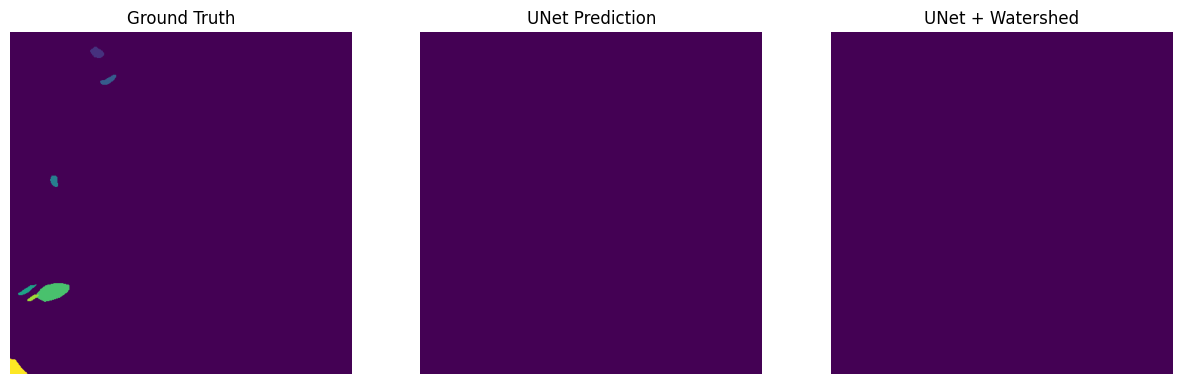

In [ ]:
import matplotlib.pyplot as plt

# Pick an index of the validation image you want to visualize
idx = 0

# Ground truth mask
gt_mask = validation_set_label[idx]

# Predicted mask (raw UNet)
pred_mask = output_raw  # make sure it's the corresponding output for idx

# Predicted mask (watershed)
pred_watershed = output_watershed  # make sure it's the corresponding output for idx

# Display side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(gt_mask)
axs[0].set_title('Ground Truth')
axs[0].axis('off')

axs[1].imshow(pred_mask)
axs[1].set_title('UNet Prediction')
axs[1].axis('off')

axs[2].imshow(pred_watershed)
axs[2].set_title('UNet + Watershed')
axs[2].axis('off')

plt.show()


All files from 'output_model/' saved to Google Drive at /content/drive/My Drive/NuInsSeg/first_run_models
